In [31]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Flatten, Dropout, Concatenate, BatchNormalization, GlobalMaxPooling2D, GlobalAveragePooling2D, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.models import Sequential
from keras.models import Model
from keras import applications
from keras import optimizers

from tqdm import tqdm

import seaborn as sns

import os

%matplotlib inline

In [32]:
SEED = 99

HEIGHT = 32
WIDTH = 32

FULL_PATH = os.path.join("..", "input")
TRAIN_DIR = os.path.join(FULL_PATH, "train", "train")
TEST_DIR = os.path.join(FULL_PATH, "test", "test")
LABELS = os.path.join(FULL_PATH, "train.csv")

In [33]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [34]:
def plot_acc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [35]:
train = pd.read_csv(LABELS)

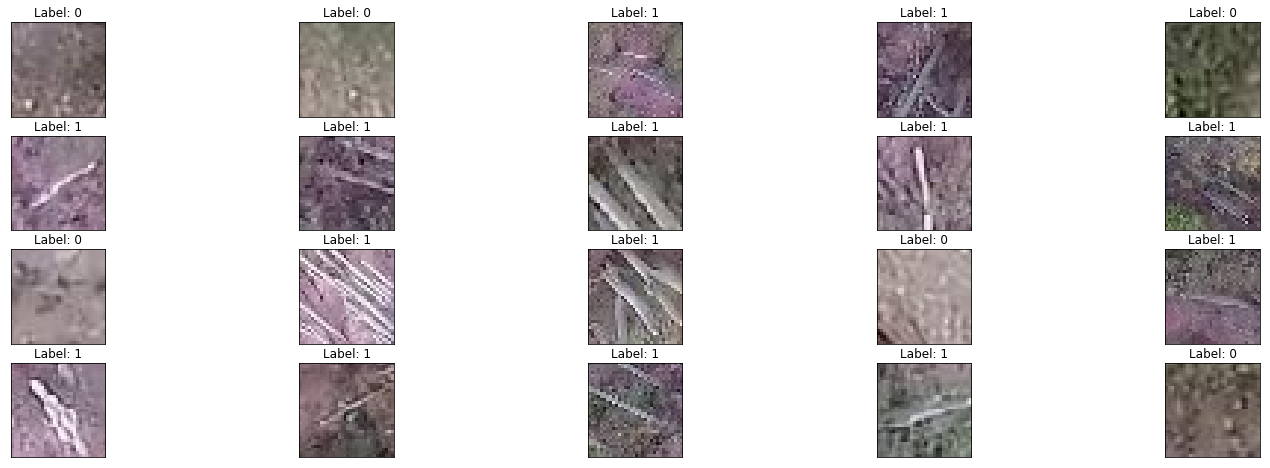

In [36]:
fig = plt.figure(figsize=(25, 8))
train_imgs = os.listdir(TRAIN_DIR)
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(4, 20//4, idx+1, xticks=[], yticks=[])
    im = Image.open(os.path.join(TRAIN_DIR, img))
    plt.imshow(im)
    lab = train.loc[train['id'] == img, 'has_cactus'].values[0]
    ax.set_title(f'Label: {lab}')

In [37]:
x_train, x_test, y_train, y_test = train_test_split(train['id'], 
                                                    train['has_cactus'], 
                                                    test_size=0.2,
                                                    random_state=3)

In [38]:
X_train = []
for img in tqdm(x_train):
    path = os.path.join(TRAIN_DIR, img)
    X_train.append(plt.imread(path))

X_test = []
for img in tqdm(x_test):
    path = os.path.join(TRAIN_DIR, img)
    X_test.append(plt.imread(path))

    
X_train = np.array(X_train)
X_test = np.array(X_test)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

100%|██████████| 3500/3500 [00:02<00:00, 1576.51it/s]


In [39]:
augmentations = ImageDataGenerator(
    vertical_flip=True,
    horizontal_flip=True,
    zoom_range=0.1)

augmentations.fit(X_train)

In [40]:
inputs = Input((32,32,3))
model_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(32,32,3))
x = model_base(inputs)
x_1 = GlobalMaxPooling2D()(x)
x_2 = GlobalAveragePooling2D()(x)
x_3 = Flatten()(x)
x = Concatenate(axis=-1)([x_1,x_2,x_3])
x = Dropout(0.5)(x)
x = Dense(256,activation='relu')(x)
x = Dense(1,activation='sigmoid')(x)

for layer in model_base.layers:
    layer.trainable = True

model = Model(inputs,x)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
densenet121 (Model)             (None, 1, 1, 1024)   7037504     input_5[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 1024)         0           densenet121[1][0]                
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 1024)         0           densenet121[1][0]                
__________________________________________________________________________________________________
flatten_3 

In [41]:
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [early_stop, reduce]

In [42]:
# opt = optimizers.SGD(lr=1e-3)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [43]:
epochs = 50

history = model.fit_generator(
    augmentations.flow(X_train, 
                       y_train, 
                       batch_size=16),
    validation_data=(X_test, y_test),
    steps_per_epoch=150,
    validation_steps=150,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
150/150 [==============================] - 62s 412ms/step - loss: 0.4699 - acc: 0.8675 - val_loss: 1.0955 - val_acc: 0.8214
Epoch 2/50
150/150 [==============================] - 20s 131ms/step - loss: 0.3982 - acc: 0.8908 - val_loss: 2.3888 - val_acc: 0.7874
Epoch 3/50
150/150 [==============================] - 20s 132ms/step - loss: 0.4048 - acc: 0.8796 - val_loss: 2.9024 - val_acc: 0.7786
Epoch 4/50
150/150 [==============================] - 20s 132ms/step - loss: 0.2709 - acc: 0.9196 - val_loss: 0.3266 - val_acc: 0.8743
Epoch 5/50
150/150 [==============================] - 20s 131ms/step - loss: 0.1899 - acc: 0.9363 - val_loss: 0.1072 - val_acc: 0.9560
Epoch 6/50
150/150 [==============================] - 20s 131ms/step - loss: 0.1879 - acc: 0.9371 - val_loss: 0.1597 - val_acc: 0.9483
Epoch 7/50
150/150 [==============================] - 20s 131ms/step - loss: 0.1555 - acc: 0.9558 - val_loss: 0.3141 - val_acc: 0.9089
Epoch 8/50
150/150 [==============================] - 2

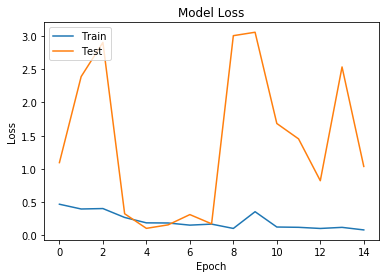

In [44]:
plot_loss(history)

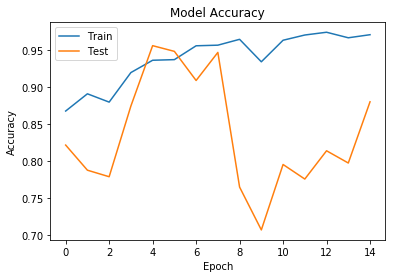

In [45]:
plot_acc(history)

In [46]:
[loss, accuracy] = model.evaluate(X_test, y_test)
print('Test Set Accuracy: ', str(accuracy*100), "%")

3500/3500 [==============================] - 2s 650us/step
Test Set Accuracy:  87.99999999318804 %


In [48]:
sample = pd.read_csv('../input/sample_submission.csv')
images_test = []
for images in tqdm(sample['id']):
    img = plt.imread('../input/test/test/' + images)
    images_test.append(img)

images_test = np.array(images_test)
images_test = images_test.astype(np.float32)
images_test /= 255

100%|██████████| 4000/4000 [00:02<00:00, 1686.23it/s]


In [49]:
prediction = model.predict(images_test)

In [50]:
submission = pd.read_csv(os.path.join(FULL_PATH, "sample_submission.csv"))
submission['has_cactus'] = prediction

In [51]:
submission.to_csv('sample_submission.csv', index = False)

In [52]:
submission.head(10)

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.999998
1,0017242f54ececa4512b4d7937d1e21e.jpg,1.000000
2,001ee6d8564003107853118ab87df407.jpg,0.206049
3,002e175c3c1e060769475f52182583d0.jpg,0.111686
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.976175
5,0038ed6f7417b8275b393307f66cb1e3.jpg,1.000000
6,0059dfa41de4441fc23b9a4b98ba99cb.jpg,1.000000
7,0061bd302d735db829418cb90b4e6040.jpg,1.000000
8,00754573d8c7223e73da553dd43780bd.jpg,1.000000
9,008d9fce71c8e03a4c9cdd15ea908573.jpg,0.117764


In [53]:
train_pred = model.predict(X_train, verbose= 1)
valid_pred = model.predict(X_test, verbose= 1)

train_acc = roc_auc_score(np.round(train_pred), y_train)
valid_acc = roc_auc_score(np.round(valid_pred), y_test)

confusion_matrix(np.round(valid_pred), y_test)

3500/3500 [==============================] - 2s 632us/step


array([[ 633,  214],
       [ 206, 2447]])